In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement_t = Base.classes.measurement
station_t = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect culumns of tables
inspector = inspect(engine)
inspector.get_table_names()
columnmeasurement = inspector.get_columns('measurement')
columnstation = inspector.get_columns('station')
print("Measurent Columns\n-------------")
for column in columnmeasurement:
    print(column["name"], f"({column['type']})")
print("\nStation Columns\n-------------")
for column in columnstation:
    print(column["name"], f"({column['type']})")

Measurent Columns
-------------
id (INTEGER)
station (TEXT)
date (TEXT)
prcp (FLOAT)
tobs (FLOAT)

Station Columns
-------------
id (INTEGER)
station (TEXT)
name (TEXT)
latitude (FLOAT)
longitude (FLOAT)
elevation (FLOAT)


In [10]:
# Find the most recent date in the data set.
latest_date = session.query(measurement_t.date).order_by(measurement_t.date.desc()).first()[0]
print(f"{latest_date} is the most recent date in the data set.")

2017-08-23 is the most recent date in the data set.


Text(0.5, 1.0, 'Last 12 months of precipitation data')

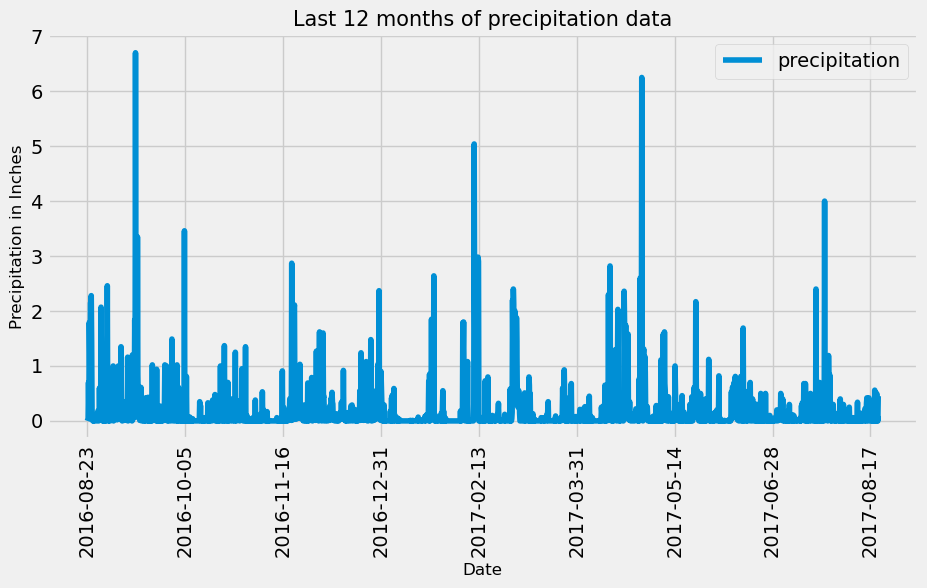

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
from dateutil.relativedelta import relativedelta

# last_datapoint = session.query(measurement_t.date).order_by(measurement_t.date.desc()).first()[0]
# print(f"Last precipitation datapoint date: {latest_date}")
last_datapoint = latest_date.split("-")

y = int(last_datapoint[0])
m = int(last_datapoint[1])
d = int(last_datapoint[2])
last_datapoint = dt.date(y, m, d)

# Calculate the date one year from the last date in data set.
first_datapoint = last_datapoint - relativedelta(years=1)
# print(f"First precipitation datapoint date: {first_datapoint}")

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(measurement_t.date, measurement_t.prcp).filter(measurement_t.date >= first_datapoint).all()
last_12_months_df = pd.DataFrame(last_12_months)

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_months_df = pd.DataFrame(last_12_months).set_index('date')

last_12_months_df.rename(columns = {'prcp': 'precipitation'}, inplace = True)

last_12_months_df.dropna(inplace =  True)

# Sort the dataframe by date
last_12_months_df.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
last_12_months_df.plot(figsize=(10,5), rot = 90)
plt.xlabel("Date",  size = 12)
plt.ylabel("Precipitation in Inches", size = 12)
plt.title("Last 12 months of precipitation data", size = 15)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_months_df.describe(include='all')

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
tot_stations = session.query(func.count(station_t.station)).all()[0][0]
print(f"{tot_stations} stations in the dataset")

9 stations in the dataset


In [14]:
# print("Measurent Columns\n-------------")
# for column in columnmeasurement:
#     print(column["name"], f"({column['type']})")
# print("\nStation Columns\n-------------")
# for column in columnstation:
#     print(column["name"], f"({column['type']})")

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement_t.station, station_t.name, func.count(station_t.id).\
                                    label("observation_counts")).group_by(station_t.id).order_by(func.count(station_t.id).\
                                    desc()).filter(station_t.station == measurement_t.station).all()
most_active_stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
sel = [measurement_t.station, 
       func.min(measurement_t.tobs), 
       func.max(measurement_t.tobs), 
       func.avg(measurement_t.tobs)]

summary = session.query(*sel).filter(measurement_t.station == most_active_station_id).all()
print(f'''
Lowest, Highest, and Average temperatures for station '{most_active_stations[0][1]}'
---------------------------------------------------------------------------
Lowest Temperature:   {summary[0][1]}
Hiighest Temperature: {summary[0][2]}
Average Temperature:  {summary[0][3]}
''')


Lowest, Highest, and Average temperatures for station 'WAIHEE 837.5, HI US'
---------------------------------------------------------------------------
Lowest Temperature:   54.0
Hiighest Temperature: 85.0
Average Temperature:  71.66378066378067



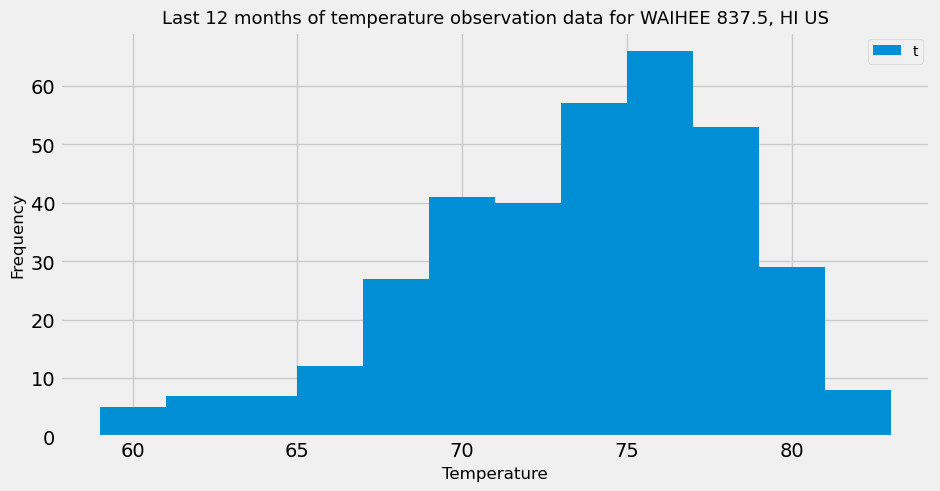

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_tobs = session.query(measurement_t.tobs).filter(measurement_t.station == most_active_station_id).\
                filter(measurement_t.date >= first_datapoint).all()

last_year_tobs = pd.DataFrame(last_year_tobs)
last_year_tobs.head()

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.hist(last_year_tobs, bins = 12)
plt.xlabel("Temperature",  size = 12)
plt.ylabel("Frequency", size = 12)
plt.title(f"Last 12 months of temperature observation data for {most_active_stations[0][1]}", size = 13)
plt.legend("tobs", loc=1, fontsize=10)

plt.show()

# Close session

In [18]:
# Close Session
session.close()